In [1]:
#velocity reconstruction: for single smoothing scale, vlin_interp removed from data channel, separated baseline for linear theory comparison,
# cnn input: density

import os, time, random
import numpy as np, h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import RegularGridInterpolator
from numpy.fft import fftn, ifftn, fftfreq

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

In [2]:
GRID_FILE = "Grids_Mcdm_IllustrisTNG_1P_128_z=0.0.npy"
TRAIN_HALO_FILE = "groups_090_1P_0.hdf5"
TEST_HALO_FILE  = "groups_090_1P_p2_n1.hdf5"   
TRAIN_REAL_IDX = 0
TEST_REAL_IDX = 14

PATCH = 32
BATCH = 16           
EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-5
MASS_CUT = 1e11
BOXSIZE = 25.0
MAX_HALOS = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUGMENT = True
PATIENCE = 14
SMOOTH_SCALE = 2.0
CHECKPOINT_DIR = "checkpoints_no_vlin_improved_v2"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


PEARSON_WEIGHT = 0.08

# test-time augmentation toggle (flip x/y)
TTA = True

print("Device:", DEVICE)


Device: cuda


In [3]:
def memmap_grid_slices(grid_file, idxs):
    if isinstance(idxs, int): idxs = [idxs]
    arr = np.load(grid_file, allow_pickle=False, mmap_mode='r')
    return [np.asarray(arr[i], dtype=np.float32) for i in idxs]

In [4]:
def load_halos(hfile):
    with h5py.File(hfile, "r") as f:
        pos = np.array(f["Group/GroupPos"]) / 1000.0  # ckpc/h -> Mpc/h
        vel = np.array(f["Group/GroupVel"])
        mass = np.array(f["Group/Group_M_Mean200"]) * 1e10
    return pos, vel, mass


In [5]:
def smooth_density_kspace(rho_cdm, R_smooth, boxsize=BOXSIZE):
    rho = np.asarray(rho_cdm, dtype=np.float32)
    delta = rho / rho.mean() - 1.0
    if R_smooth == 0.0:
        return delta.astype(np.float32)
    N = rho.shape[0]
    dk = fftn(delta)
    kfreq = fftfreq(N, d=boxsize/N)
    kx, ky, kz = np.meshgrid(2*np.pi*kfreq, 2*np.pi*kfreq, 2*np.pi*kfreq, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    W = np.exp(-0.5 * k2 * (R_smooth**2))
    return ifftn(dk * W).real.astype(np.float32)


In [6]:
def compute_vlin_from_density(rho_cdm, z_snap=0.0, boxsize=BOXSIZE,
                              H0=67.66, Omega_m0=0.3, R_smooth=2.0):
    N = rho_cdm.shape[0]
    a = 1.0 / (1.0 + z_snap)
    Hz = H0 * np.sqrt(Omega_m0 * (1+z_snap)**3 + 1.0 - Omega_m0)
    f = (Omega_m0*(1+z_snap)**3 / (Omega_m0*(1+z_snap)**3 + 1.0 - Omega_m0))**0.55
    delta_x = rho_cdm / np.mean(rho_cdm) - 1.0
    dk = fftn(delta_x)
    kfreq = fftfreq(N, d=boxsize/N)
    kx, ky, kz = np.meshgrid(2*np.pi*kfreq, 2*np.pi*kfreq, 2*np.pi*kfreq, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    k2_nozero = np.where(k2 == 0, 1.0, k2)
    pref = 1j * a * Hz * f
    vz_k = pref * (kz / k2_nozero) * dk
    vz_k[k2 == 0] = 0.0
    if R_smooth is not None and R_smooth > 0.0:
        W = np.exp(-0.5 * k2 * (R_smooth**2))
        vz_k *= W
    vz_x = ifftn(vz_k).real
    return vz_x.astype(np.float32)

In [7]:
def build_vlin_interpolator(vlin_grid):
    N = vlin_grid.shape[0]
    cell = BOXSIZE / N
    coords = (np.arange(N) + 0.5) * cell
    return RegularGridInterpolator((coords, coords, coords), vlin_grid,
                                   bounds_error=False, fill_value=0.0)


In [8]:
# ---------------- Dataset ----------------
class DensityOnlyHaloDataset(Dataset):
    def __init__(self, grids_channels, pos, vel, mass,
                 mass_cut=MASS_CUT, max_n=MAX_HALOS, augment=AUGMENT, rng=None):
        if rng is None:
            rng = np.random.RandomState(SEED)
        mask = mass > mass_cut
        pos_sel, vel_sel, mass_sel = pos[mask], vel[mask], mass[mask]
        # deterministic downsample
        if max_n is not None and len(pos_sel) > max_n:
            sel = rng.choice(len(pos_sel), max_n, replace=False)
            pos_sel, vel_sel, mass_sel = pos_sel[sel], vel_sel[sel], mass_sel[sel]

        self.pos = pos_sel
        self.vz = vel_sel[:, 2].astype(np.float32)
        self.mass = mass_sel.astype(np.float32)
        self.grids = grids_channels
        self.N = self.grids[0].shape[0]
        self.patch = PATCH
        self.augment = augment

        print(f"Selected {len(self.pos)} halos (mass_cut={mass_cut}, cap={max_n}).")

    def __len__(self):
        return len(self.pos)

    def _extract_patch_single(self, grid, center):
        N = grid.shape[0]
        cell = BOXSIZE / N
        idx = (center / cell - 0.5).astype(int)
        r = self.patch // 2
        xs = [(idx[0] + i) % N for i in range(-r, r)]
        ys = [(idx[1] + i) % N for i in range(-r, r)]
        zs = [(idx[2] + i) % N for i in range(-r, r)]
        return grid[np.ix_(xs, ys, zs)]

    def __getitem__(self, idx):
        c = self.pos[idx]
        patches = []
        for g in self.grids:
            p = self._extract_patch_single(g, c)
            patches.append(np.asarray(p, dtype=np.float32))

        #P = self.patch
        x = np.stack(patches, axis=0)
        x = np.clip(x, -6.0, 6.0)

        if self.augment:
            if np.random.rand() < 0.5:
                x = x[:, ::-1, :, :].copy()
            if np.random.rand() < 0.5:
                x = x[:, :, ::-1, :].copy()
            k = np.random.randint(4)
            if k:
                x = np.rot90(x, k=k, axes=(1, 2)).copy()


        y = float(self.vz[idx])

        return np.ascontiguousarray(x, dtype=np.float32), np.float32(y)


In [10]:
def conv3d_gn(in_ch, out_ch, kernel=3, stride=1, padding=1, ngroups=8):
    g = min(ngroups, out_ch)
    while out_ch % g != 0 and g > 1:
        g -= 1
    return nn.Sequential(
        nn.Conv3d(in_ch, out_ch, kernel_size=kernel, stride=stride,
                  padding=padding, bias=False),
        nn.GroupNorm(num_groups=g, num_channels=out_ch),
        nn.ReLU(inplace=True)
    )

In [11]:
class ResidualBlock3D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv3d(ch, ch, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups=min(8, ch), num_channels=ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(ch, ch, kernel_size=3, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups=min(8, ch), num_channels=ch)

    def forward(self, x):
        out = self.conv1(x); out = self.gn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.gn2(out)
        return self.relu(out + x)

In [12]:
class CNN_DensityOnly(nn.Module):
    """
    CNN that uses only density channels as input.

    forward(x):
        x : (batch, C_in, P, P, P)
        returns: (batch,)   # predicted vz (normalized)
    """
    def __init__(self, in_ch, base_ch=40, dropout=0.15, n_blocks=2):
        super().__init__()

        self.conv_in = conv3d_gn(in_ch, base_ch)
        self.down1 = nn.Sequential(
            nn.MaxPool3d(2),
            conv3d_gn(base_ch, base_ch * 2)
        )
        self.res1 = nn.Sequential(
            *[ResidualBlock3D(base_ch * 2) for _ in range(n_blocks)]
        )
        self.down2 = nn.Sequential(
            nn.MaxPool3d(2),
            conv3d_gn(base_ch * 2, base_ch * 4)
        )
        self.res2 = nn.Sequential(
            *[ResidualBlock3D(base_ch * 4) for _ in range(n_blocks)]
        )
        self.avgpool = nn.AdaptiveAvgPool3d(1)
        feat = base_ch * 4

        # NOTE: head input is just feat, no +1
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GroupNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # INPUT: x (batch, C_in, P, P, P)
        x = self.conv_in(x)
        x = self.down1(x)
        x = self.res1(x)
        x = self.down2(x)
        x = self.res2(x)

        f = self.avgpool(x).view(x.size(0), -1)   # (batch, feat)
        out = self.head(f).view(-1)               # (batch,)
        return out


In [13]:
def pearson_corr_torch(x, y, eps=1e-6):
    # x, y: tensors (batch,)
    xm = torch.mean(x)
    ym = torch.mean(y)
    xm0 = x - xm
    ym0 = y - ym
    cov = torch.mean(xm0 * ym0)
    sx = torch.sqrt(torch.mean(xm0 * xm0) + eps)
    sy = torch.sqrt(torch.mean(ym0 * ym0) + eps)
    corr = cov / (sx * sy + eps)
    return corr

In [14]:
def _compute_stats(true, pred):
    mask = np.isfinite(true) & np.isfinite(pred)
    n = int(mask.sum())
    if n == 0:
        return mask, np.nan, np.nan, np.nan, np.nan, np.nan, n
    t = true[mask]; p = pred[mask]
    try:
        corr = float(pearsonr(t, p)[0])
    except Exception:
        corr = np.nan
    bias = float(np.mean(p - t))
    rmse = float(np.sqrt(np.mean((p - t) ** 2)))
    rms_true = float(np.std(t))
    rms_pred = float(np.std(p))
    return mask, corr, bias, rmse, rms_true, rms_pred, n

In [15]:
def hexbin_panel(ax, true, pred, title, cmap="viridis"):
    mask, corr, bias, rmse, rms_true, rms_pred, n = _compute_stats(true, pred)
    vmax = max(np.max(np.abs(true[mask])), np.max(np.abs(pred[mask]))) if n > 0 else 1.0
    lims = [-vmax, vmax]

    hb = ax.hexbin(
        true[mask], pred[mask],
        gridsize=150,
        cmap=cmap,
        bins='log',
        mincnt=1,
        extent=(lims[0], lims[1], lims[0], lims[1])
    )

    ax.plot(lims, lims, 'r--', lw=1.2, label="1:1")
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("True LOS velocity (km/s)")
    ax.set_ylabel("Predicted LOS velocity (km/s)")
    ax.set_title(f"{title}\nρ = {corr:.3f}")

    stats_text = (
        f"N = {n}\n"
        f"ρ = {corr:.3f}\n"
        f"Bias = {bias:.2f}\n"
        f"RMSE = {rmse:.2f}\n"
        f"RMS(true) = {rms_true:.2f}\n"
        f"RMS(pred) = {rms_pred:.2f}"
    )

    ax.text(
        0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=9,
        va='top',
        bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.85)
    )
    return hb

In [16]:
def vlin_at_halos(vlin_grid, halo_pos):
    """Interpolate linear-theory vz field at halo positions."""
    interp = build_vlin_interpolator(vlin_grid)
    pos_wrapped = (halo_pos % BOXSIZE)
    vals = [np.asarray(interp(tuple(p))).item() for p in pos_wrapped]
    return np.array(vals, dtype=np.float32)


In [17]:
def train_and_eval():
    """
    Train density-only CNN on (GRID_FILE, TRAIN_REAL_IDX, TRAIN_HALO_FILE),
    then evaluate once on (TEST_REAL_IDX, TEST_HALO_FILE).
    """
    # 1) Load grids
    grid_train, grid_test = memmap_grid_slices(GRID_FILE, [TRAIN_REAL_IDX, TEST_REAL_IDX])
    print("Grid shapes (train, test):", grid_train.shape, grid_test.shape)

    # 2) Multi-scale density channels
    print("Building multi-scale overdensity channels...")
    channels_train_raw = [ smooth_density_kspace(grid_train, SMOOTH_SCALE)]
    channels_test_raw  = [ smooth_density_kspace(grid_test,  SMOOTH_SCALE) ]

    # Train normalization per channel
    a_train = np.asarray(channels_train_raw[0], dtype=np.float32)
    am, ast = float(a_train.mean()), float(a_train.std()) + 1e-12
    train_ch_stats = [(am, ast)]
    channels_train = [ ((a_train - am) / ast).astype(np.float32) ]

    a_test = np.asarray(channels_test_raw[0], dtype=np.float32)
    channels_test = [ ((a_test - am) / ast).astype(np.float32) ]

    # 3) Load halos
    pos_tr, vel_tr, mass_tr = load_halos(TRAIN_HALO_FILE)
    pos_te, vel_te, mass_te = load_halos(TEST_HALO_FILE)
    print("Loaded halos (train, test):", len(pos_tr), len(pos_te))

    # 4) Datasets and loaders (density-only)
    rng = np.random.RandomState(SEED)
    train_ds_full = DensityOnlyHaloDataset(channels_train, pos_tr, vel_tr, mass_tr,
                                           mass_cut=MASS_CUT, max_n=MAX_HALOS,
                                           augment=AUGMENT, rng=rng)
    test_ds = DensityOnlyHaloDataset(channels_test, pos_te, vel_te, mass_te,
                                     mass_cut=MASS_CUT, max_n=MAX_HALOS,
                                     augment=False, rng=rng)
     # 5) v_lin baseline 
    print("Computing v_lin baseline (on CNN test halos)...")
    vlin_test = compute_vlin_from_density(grid_test, R_smooth=2.0)
    vlin_baseline = vlin_at_halos(vlin_test, test_ds.pos)   # uses mass-cut sample
    v_true_test   = test_ds.vz                              # same sample

    try:
        rho_vlin = pearsonr(v_true_test, vlin_baseline)[0]
    except Exception:
        rho_vlin = np.nan
    print(f"ρ (v_lin baseline, mass-cut halos) = {rho_vlin:.4f}")

    idxs = np.arange(len(train_ds_full))
    tr_idx, val_idx = train_test_split(idxs, test_size=0.2, random_state=SEED)

    # Collect vz for normalization
    y_train_vals = np.array([train_ds_full[i][1] for i in tr_idx], dtype=np.float32)
    y_mean = float(y_train_vals.mean())
    y_std  = float(y_train_vals.std() + 1e-12)
    print("Train vz mean/std:", y_mean, y_std)

    tr_ds = Subset(train_ds_full, tr_idx)
    val_ds = Subset(train_ds_full, val_idx)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    te_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=0)

    # 6) Model / optimizer / loss
    in_ch = 1  # number of density channels
    model = CNN_DensityOnly(in_ch=in_ch, base_ch=40, dropout=0.15, n_blocks=2).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=6, min_lr=1e-6
    )
    loss_fn = nn.SmoothL1Loss()

    best_val = np.inf
    best_epoch = -1
    best_ckpt = os.path.join(CHECKPOINT_DIR, "cnn_best_density_only.pth")
    no_improve = 0

    # 7) TRAINING LOOP
    for epoch in range(EPOCHS):
        t0 = time.time()
        model.train()
        running_loss = 0.0

        for x_in, vz_true in tr_loader:
            # ----- INPUT to CNN -----
            # x_in : (batch, C_in, P, P, P)
            # vz_true : (batch,)
            x_in   = x_in.to(DEVICE)
            vz_true = vz_true.to(DEVICE)

            # Normalize target
            vz_true_norm = (vz_true - y_mean) / y_std

            # ----- FORWARD PASS (MODEL OUTPUT) -----
            vz_pred_norm = model(x_in)              # (batch,)
            vz_pred      = vz_pred_norm * y_std + y_mean   # de-normalized

            # ----- LOSS -----
            base_loss = loss_fn(vz_pred_norm, vz_true_norm)
            p = pearson_corr_torch(vz_pred, vz_true)   # correlation term
            pearson_loss = 1.0 - p
            loss = base_loss + PEARSON_WEIGHT * pearson_loss

            # ----- BACKPROP -----
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

            running_loss += loss.item() * x_in.size(0)

        train_loss = running_loss / len(tr_ds)

        # ---- VALIDATION ----
        model.eval()
        val_loss_sum = 0.0
        val_preds = []
        val_trues = []
        with torch.no_grad():
            for x_in, vz_true in val_loader:
                x_in   = x_in.to(DEVICE)
                vz_true = vz_true.to(DEVICE)
                vz_true_norm = (vz_true - y_mean) / y_std

                vz_pred_norm = model(x_in)
                vz_pred      = vz_pred_norm * y_std + y_mean

                val_preds.append(vz_pred.cpu().numpy().ravel())
                val_trues.append(vz_true.cpu().numpy().ravel())

                val_loss_sum += ((vz_pred_norm - vz_true_norm)**2).mean().item() * x_in.size(0)

        val_loss = val_loss_sum / len(val_ds)
        val_preds = np.concatenate(val_preds) if val_preds else np.array([])
        val_trues = np.concatenate(val_trues) if val_trues else np.array([])
        try:
            val_rho = pearsonr(val_trues, val_preds)[0]
        except Exception:
            val_rho = np.nan

        scheduler.step(val_loss)
        dt = time.time() - t0
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"TrainLoss={train_loss:.4e}  ValLoss={val_loss:.4e}  "
              f"ρ_val={val_rho:.3f}  ({dt:.1f}s)")

        if np.isfinite(val_loss) and val_loss < best_val - 1e-9:
            best_val = val_loss
            best_epoch = epoch + 1
            no_improve = 0
            torch.save(
                {'model_state_dict': model.state_dict(),
                 'y_mean': y_mean,
                 'y_std':  y_std},
                best_ckpt
            )
            print("  → Saved new best checkpoint:", best_ckpt)
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print("Early stopping.")
                break

    print(f"Training finished. Best epoch {best_epoch}, best val loss {best_val:.4e}")

    # 8) TEST on configured test set
    ckpt = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    y_mean = ckpt['y_mean']; y_std = ckpt['y_std']
    model.eval()

    preds_all = []
    trues_all = []

    with torch.no_grad():
        for x_in, vz_true in te_loader:
            x_in   = x_in.to(DEVICE)
            vz_true = vz_true.to(DEVICE)

            vz_pred_norm = model(x_in)
            vz_pred = vz_pred_norm.cpu().numpy().ravel() * y_std + y_mean

            if TTA:
                x_flip = torch.flip(x_in, dims=[2])
                vz_pred_norm_flip = model(x_flip)
                vz_pred_flip = vz_pred_norm_flip.cpu().numpy().ravel() * y_std + y_mean
                vz_pred = 0.5 * (vz_pred + vz_pred_flip)

            preds_all.append(vz_pred)
            trues_all.append(vz_true.cpu().numpy().ravel())

    v_pred = np.concatenate(preds_all) if preds_all else np.array([])
    v_true = np.concatenate(trues_all) if trues_all else np.array([])

    def safe_pearson(x, y):
        m = np.isfinite(x) & np.isfinite(y)
        if m.sum() < 3:
            return np.nan
        return pearsonr(x[m], y[m])[0]

    rho_raw = safe_pearson(v_true, v_pred)
    bias_raw = float(np.mean(v_pred - v_true))
    rmse_raw = float(np.sqrt(np.mean((v_pred - v_true)**2)))

    print("----- Test metrics (configured test set) -----")
    print(f"Raw CNN:   N={len(v_true)}, ρ={rho_raw:.4f}, "
          f"bias={bias_raw:.3f}, rmse={rmse_raw:.3f}")
    print(f"Baseline v_lin ρ (interpolated) = {rho_vlin:.4f}")

     # Plot v_lin vs CNN on new test
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    hb1 = hexbin_panel(
        axes[0], v_true_test, vlin_baseline,
        title="Linear Theory (v_lin)"
    )

    hb2 = hexbin_panel(
        axes[1], v_true, v_pred,
        title="CNN (raw)"
    )

    cb_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(hb1, cax=cb_ax, label="log(count)")

    plt.suptitle(
        f"Velocity Reconstruction (NEW TEST)\n"
        f"Train Real {TRAIN_REAL_IDX} → Test Real {TEST_REAL_IDX}",
        fontsize=16
    )

    out_compare = os.path.join(
        CHECKPOINT_DIR,
        f"vlin_vs_cnn_density_only_testReal{TEST_REAL_IDX}.png"
    )
    plt.savefig(out_compare, dpi=300, bbox_inches="tight")
    print("Saved:", out_compare)
    plt.show()


Grid shapes (train, test): (128, 128, 128) (128, 128, 128)
Building multi-scale overdensity channels...
Loaded halos (train, test): 20817 21205
Selected 547 halos (mass_cut=100000000000.0, cap=5000).
Selected 569 halos (mass_cut=100000000000.0, cap=5000).
Computing v_lin baseline (on CNN test halos)...
ρ (v_lin baseline, mass-cut halos) = 0.8551
Train vz mean/std: -1.0862698554992676 105.11466979980469
Epoch   1/60 | TrainLoss=4.3392e-01  ValLoss=8.2542e-01  ρ_val=0.723  (11.5s)
  → Saved new best checkpoint: checkpoints_no_vlin_improved_v2/cnn_best_density_only.pth
Epoch   2/60 | TrainLoss=3.0745e-01  ValLoss=5.0357e-01  ρ_val=0.752  (10.9s)
  → Saved new best checkpoint: checkpoints_no_vlin_improved_v2/cnn_best_density_only.pth
Epoch   3/60 | TrainLoss=2.5646e-01  ValLoss=3.7288e-01  ρ_val=0.800  (11.0s)
  → Saved new best checkpoint: checkpoints_no_vlin_improved_v2/cnn_best_density_only.pth
Epoch   4/60 | TrainLoss=2.4126e-01  ValLoss=4.0647e-01  ρ_val=0.789  (11.1s)
Epoch   5/60 | 

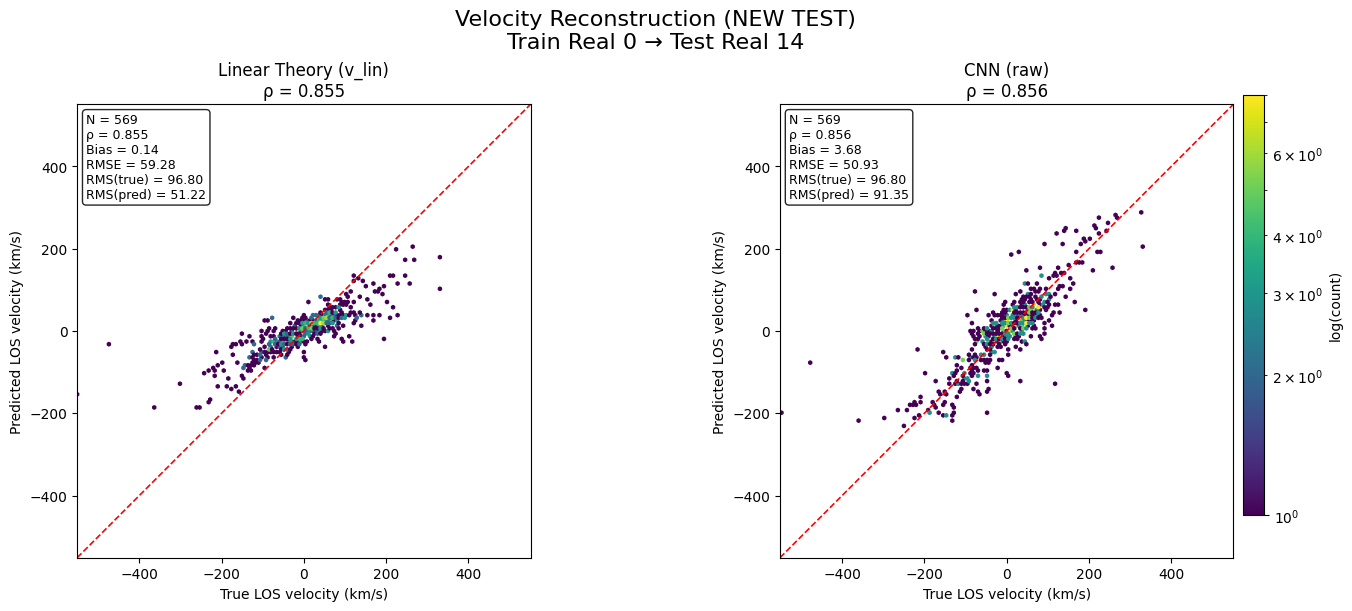

In [18]:
train_and_eval()